In [14]:
#! pip install -U numba pyod

In [12]:
import numpy as np 
import pandas as pd
import random
import warnings
import sys
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support

sys.path.append('../')
sys.path.append('../../')
from ACME.ACME import ACME
from ACME.visual_utils import * 
from anomaly_detection_notebook.ad_datasets.synthetic_data_generation import *
from anomaly_detection_notebook.ad_datasets.plot_dataset_utils import *
sys.path.remove('../')
sys.path.remove('../../')

warnings.filterwarnings('ignore')

np.random.seed(0)
random.seed(0)

# AcME-AD to explain Isolation Forest on synthetic dataset 
Explanation of anomalies in the test set, not already present in the training set.

In [2]:
# training dataset 
n_inliers, n_outliers = 900, 100 
dim = 6 
inliers_interval = [0, 3]
outliers_interval = [4, 30]
data = DIFFI_dataset(n_inliers, n_outliers, inliers_interval, outliers_interval, dim)
features = data.drop(columns=['Target']).columns

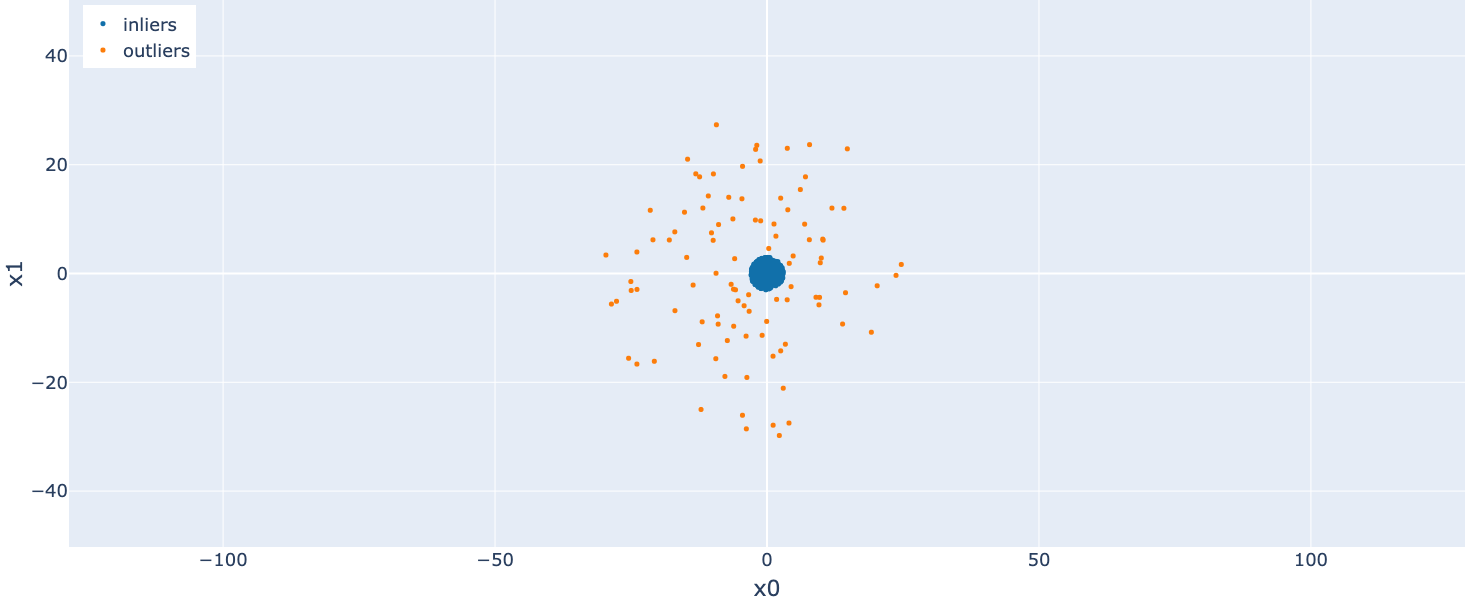

In [3]:
# plot training dataset
training_data_synthetic_fig = plot_anomaly_dataset_2d(data, "Target", features = features[:2], marker_size=5)
training_data_synthetic_fig.update_layout(width=600, height=600, font_size=18, margin=dict(l=0, r=0, b=0, t=0),)
training_data_synthetic_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
training_data_synthetic_fig.update_layout(xaxis=dict(range=[-46, 46]), yaxis=dict(range=[-46, 46]))
training_data_synthetic_fig.show()

In [4]:
# Test dataset
n_x, n_y, n_bisec = 100, 100, 100 

x_outliers1 = generate_axis(int(n_x/2), 0, axis_min = 10, axis_max = 40, size = 6)
x_outliers2 = generate_axis(int(n_x/2), 0, axis_min = -40, axis_max = -10, size = 6)
x_outliers = pd.DataFrame(np.concatenate([x_outliers1, x_outliers2], axis = 0), columns = features)
x_outliers["Type"] = "x_axis"

y_outliers1 = generate_axis(int(n_y/2), 1, axis_min = 10, axis_max = 40, size = 6)
y_outliers2 = generate_axis(int(n_y/2), 1, axis_min = -40, axis_max = -10, size = 6)
y_outliers = pd.DataFrame(np.concatenate([y_outliers1, y_outliers2], axis = 0), columns = features)
y_outliers["Type"] = "y_axis"

bisec_outliers1 = generate_bisec_2d(int(n_bisec/2), radius_min = 10, radius_max = 40, theta = np.pi/4, size = 6) 
bisec_outliers2 = generate_bisec_2d(int(n_bisec/2), radius_min = -40, radius_max = -10, theta = np.pi/4, size = 6)
bisec_outliers = pd.DataFrame(np.concatenate([bisec_outliers1, bisec_outliers2], axis = 0), columns = features)
bisec_outliers["Type"] = "bisec"

test_data = pd.concat([x_outliers, y_outliers, bisec_outliers], axis = 0)
test_data["Target"] = 1

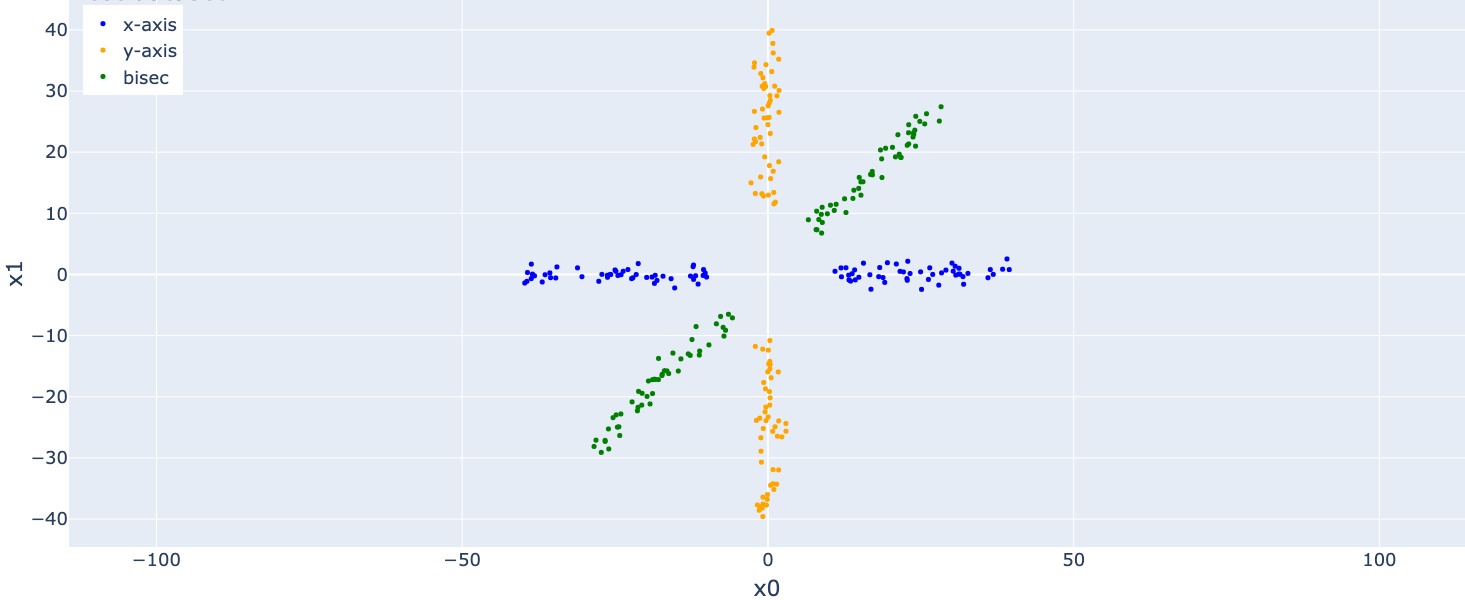

In [5]:
# plot test dataset
test_data_fig = go.Figure() 
test_data_fig.add_trace(go.Scatter(x = x_outliers[features[0]], y = x_outliers[features[1]], name="x-axis", showlegend=True, mode = "markers", marker=dict(size=5, color="blue")))
test_data_fig.add_trace(go.Scatter(x = y_outliers[features[0]], y = y_outliers[features[1]], name="y-axis", mode = "markers", showlegend=True, marker=dict(size=5, color="orange")))
test_data_fig.add_trace(go.Scatter(x = bisec_outliers[features[0]], y = bisec_outliers[features[1]], name = "bisec", mode = "markers", showlegend=True, marker=dict(size=5, color="green")))

test_data_fig.update_layout(title = "Test dataset", xaxis_title = features[0], yaxis_title = features[1])
test_data_fig.update_layout(width=600, height=600, yaxis_scaleanchor="x", yaxis_scaleratio=1, xaxis_scaleanchor="y", xaxis_scaleratio=1, margin=dict(l=0, r=0, b=0, t=0), font_size=18)
test_data_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
test_data_fig.show()

## Training and prediction of Isolation Forest

In [6]:
def if_score_function(model, data): 
    return 0.5 * (-model.decision_function(data)+1)

In [7]:
iforest = IsolationForest(n_estimators = 100, random_state = 0, max_samples = 256).fit(data[features])

data["Score"] = if_score_function(iforest, data[features])
data["Prediction"] = iforest.predict(data[features])
data["Prediction"] = data["Prediction"].apply(lambda x: 0 if x == 1 else 1)

In [8]:
precision, recall, f1, _ = precision_recall_fscore_support(data["Target"], data["Prediction"], average = "binary")
print("Training | Precision: ", round(precision,4), "| Recall: ", round(recall,4), "| F1-score: ", round(f1,4))

Training | Precision:  0.9 | Recall:  0.63 | F1-score:  0.7412


In [9]:
test_data["Score"] = if_score_function(iforest, test_data[features])
test_data["Prediction"] = iforest.predict(test_data[features])
test_data["Prediction"] = test_data["Prediction"].apply(lambda x: 0 if x == 1 else 1)

In [10]:
precision, recall, f1, _ = precision_recall_fscore_support(test_data["Target"], test_data["Prediction"], average = "binary")
print("Test | Precision: ", round(precision,4), "| Recall: ", round(recall,4), "| F1-score: ", round(f1,4))

Test | Precision:  1.0 | Recall:  0.73 | F1-score:  0.8439


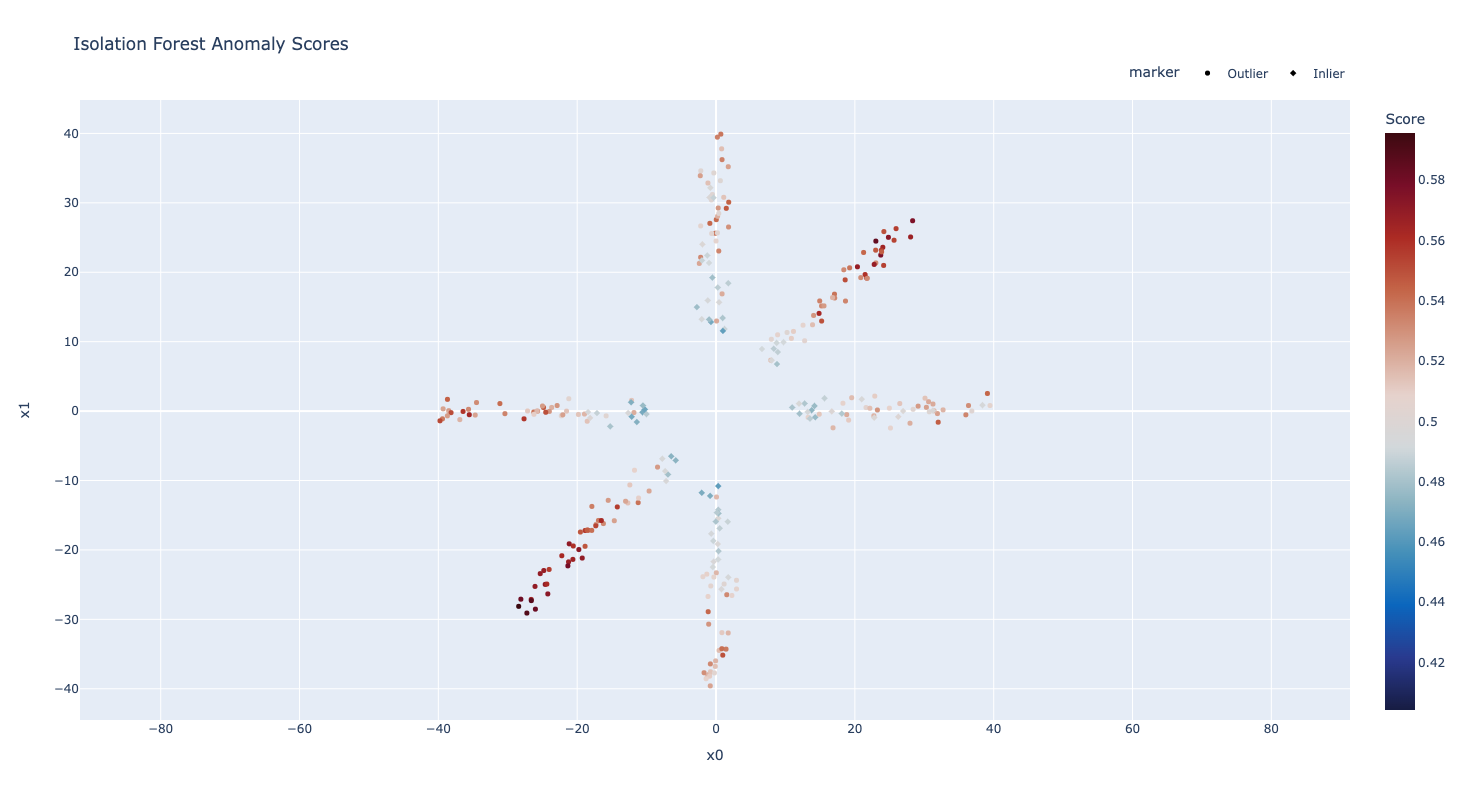

In [11]:
plot_anomaly_score_2d(test_data, "Score", title = "Isolation Forest Anomaly Scores",marker_size = 5)

## AcME-AD explanations

In [12]:
data_to_explain = test_data[test_data["Prediction"] == 1]

x_data_to_explain = data_to_explain[data_to_explain["Type"] == "x_axis"].reset_index(drop = True)
y_data_to_explain = data_to_explain[data_to_explain["Type"] == "y_axis"].reset_index(drop = True)
bisec_data_to_explain = data_to_explain[data_to_explain["Type"] == "bisec"].reset_index(drop = True)

In [13]:
n_quantiles = 70 
acme_exp = ACME(iforest, target="Score", features=features, K=n_quantiles, task="ad", score_function=if_score_function)
acme_exp = acme_exp.explain(data, True)

In [14]:
x_feature_ranking = pd.DataFrame(columns = features, data = np.zeros((len(x_data_to_explain.keys()), len(features))))
y_feature_ranking = pd.DataFrame(columns = features, data = np.zeros((len(y_data_to_explain.keys()), len(features))))
bisec_feature_ranking = pd.DataFrame(columns = features, data = np.zeros((len(bisec_data_to_explain.keys()), len(features))))

for i in x_data_to_explain.index: 
    loc_exp = acme_exp.explain_local(x_data_to_explain.loc[i])
    x_feature_ranking.loc[i] = loc_exp.feature_importance(local=True)["importance"].rank(ascending=False, method="min")
x_feature_ranking_count = x_feature_ranking.apply(pd.Series.value_counts, axis=0).fillna(0)
x_feature_ranking_count = x_feature_ranking_count/x_feature_ranking_count.sum()


for i in y_data_to_explain.index:
    loc_exp = acme_exp.explain_local(y_data_to_explain.loc[i])
    y_feature_ranking.loc[i] = loc_exp.feature_importance(local=True)["importance"].rank(ascending=False, method="min")
y_feature_ranking_count = y_feature_ranking.apply(pd.Series.value_counts, axis=0).fillna(0)
y_feature_ranking_count = y_feature_ranking_count/y_feature_ranking_count.sum()


for i in bisec_data_to_explain.index:
    loc_exp = acme_exp.explain_local(bisec_data_to_explain.loc[i])
    bisec_feature_ranking.loc[i] = loc_exp.feature_importance(local=True)["importance"].rank(ascending=False, method="min")
bisec_feature_ranking_count = bisec_feature_ranking.apply(pd.Series.value_counts, axis=0).fillna(0)
bisec_feature_ranking_count = bisec_feature_ranking_count/bisec_feature_ranking_count.sum()

Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature importance
Using default weights for anomaly detection feature imp

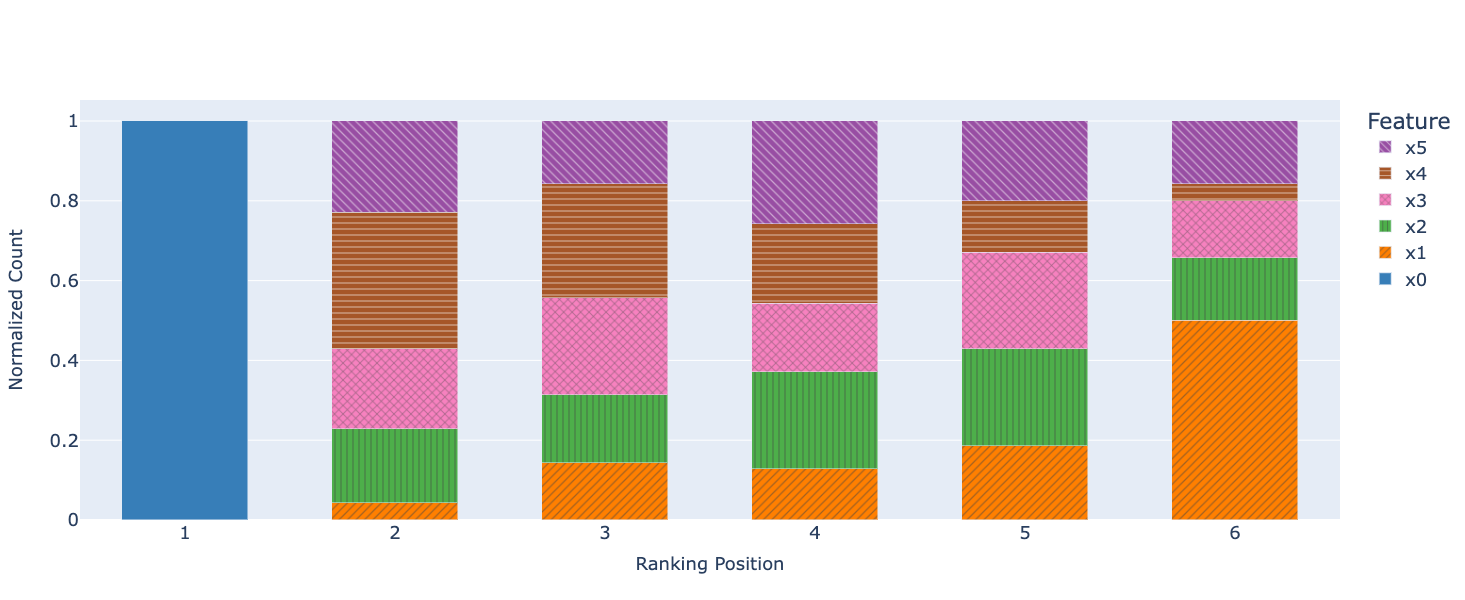

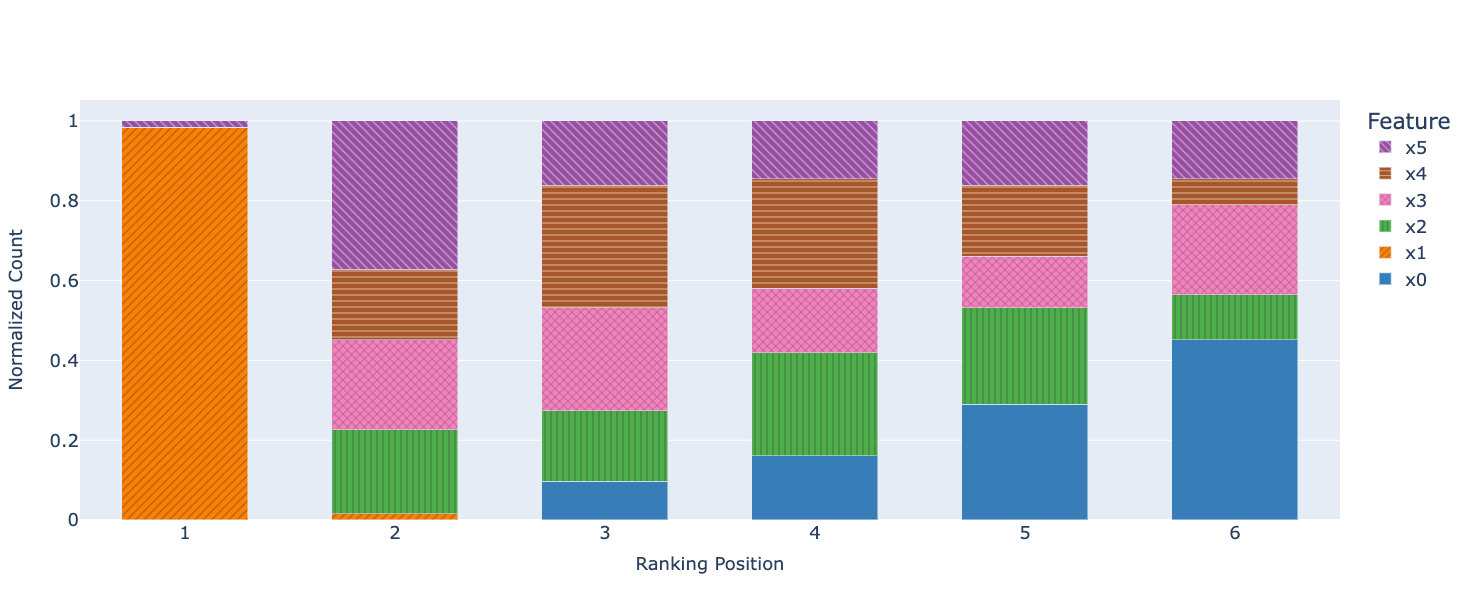

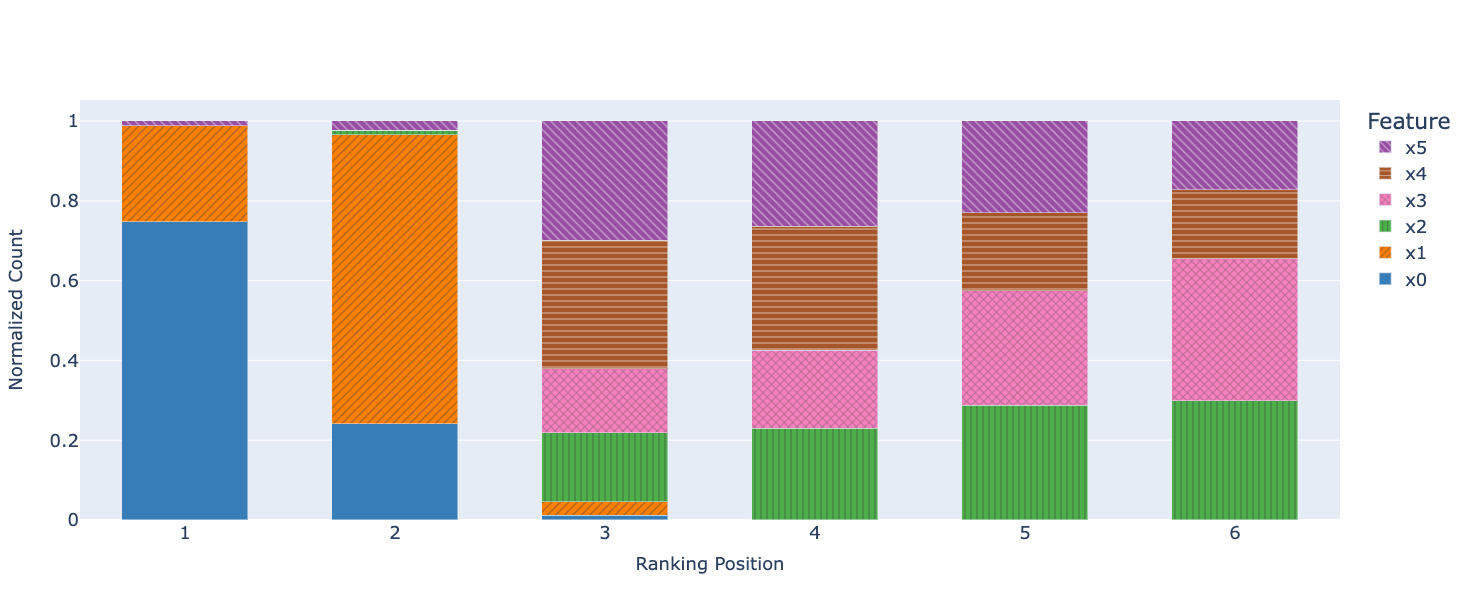

In [15]:
ranking_xaxis_fig = feature_importance_distribution_barplot(x_feature_ranking_count)
ranking_xaxis_fig.update_layout(width=10*100, height=6*100, font=dict(size=18))

ranking_yaxis_fig = feature_importance_distribution_barplot(y_feature_ranking_count)
ranking_yaxis_fig.update_layout(width=10*100, height=6*100, font=dict(size=18))

ranking_bisec_fig = feature_importance_distribution_barplot(bisec_feature_ranking_count)
ranking_bisec_fig.update_layout(width=10*100, height=6*100, font=dict(size=18))

ranking_xaxis_fig.show()
ranking_yaxis_fig.show()
ranking_bisec_fig.show()

## Comparison with KernelSHAP

In [16]:
import shap

def if_score_function_shap(X): 
    return 0.5 * (-iforest.decision_function(X)+1)

shap_exp = shap.KernelExplainer(if_score_function_shap, data = data[features].values)
shap_values_x = shap_exp.shap_values(x_data_to_explain[features].values)
shap_values_y = shap_exp.shap_values(y_data_to_explain[features].values)
shap_values_bisec = shap_exp.shap_values(bisec_data_to_explain[features].values)

df_shap_x = pd.DataFrame(abs(shap_values_x), columns = features)
df_shap_y = pd.DataFrame(abs(shap_values_y), columns = features)
df_shap_bisec = pd.DataFrame(abs(shap_values_bisec), columns = features)

shap_x_feature_ranking = pd.DataFrame(columns = features, data = np.zeros((len(x_data_to_explain.keys()), len(features))))
shap_y_feature_ranking = pd.DataFrame(columns = features, data = np.zeros((len(y_data_to_explain.keys()), len(features))))
shap_bisec_feature_ranking = pd.DataFrame(columns = features, data = np.zeros((len(bisec_data_to_explain.keys()), len(features))))

for i in range(len(x_data_to_explain)):
    order = df_shap_x.iloc[i].sort_values(ascending = False).index
    for j, feature in enumerate(order): 
        shap_x_feature_ranking.loc[i, feature] = j+1

shap_x_feature_ranking = shap_x_feature_ranking.apply(pd.Series.value_counts, axis=0).fillna(0)
shap_x_feature_ranking = shap_x_feature_ranking / shap_x_feature_ranking.sum(axis=0)

for i in range(len(y_data_to_explain)):
    order = df_shap_y.iloc[i].sort_values(ascending = False).index
    for j, feature in enumerate(order): 
        shap_y_feature_ranking.loc[i, feature] = j+1

shap_y_feature_ranking = shap_y_feature_ranking.apply(pd.Series.value_counts, axis=0).fillna(0)
shap_y_feature_ranking = shap_y_feature_ranking / shap_y_feature_ranking.sum(axis=0)

for i in range(len(bisec_data_to_explain)):
    order = df_shap_bisec.iloc[i].sort_values(ascending = False).index
    for j, feature in enumerate(order): 
        shap_bisec_feature_ranking.loc[i, feature] = j+1

shap_bisec_feature_ranking = shap_bisec_feature_ranking.apply(pd.Series.value_counts, axis=0).fillna(0)
shap_bisec_feature_ranking = shap_bisec_feature_ranking / shap_bisec_feature_ranking.sum(axis=0)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 87/87 [01:21<00:00,  1.07it/s]


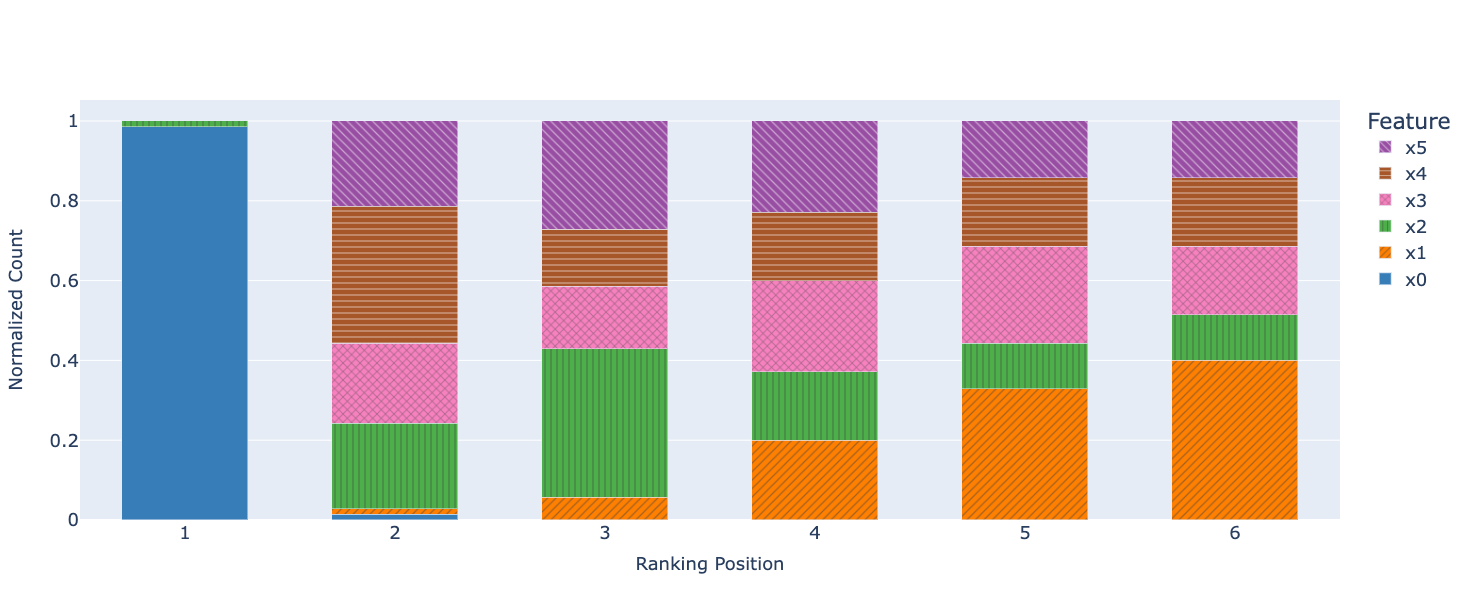

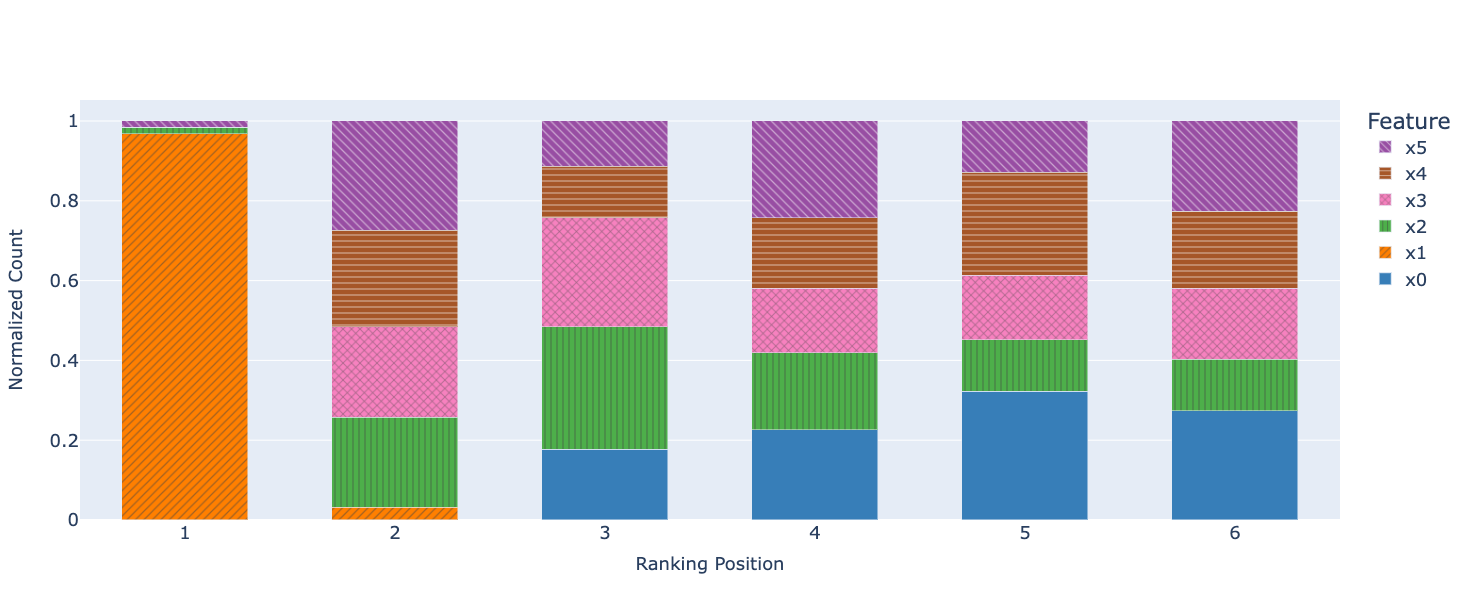

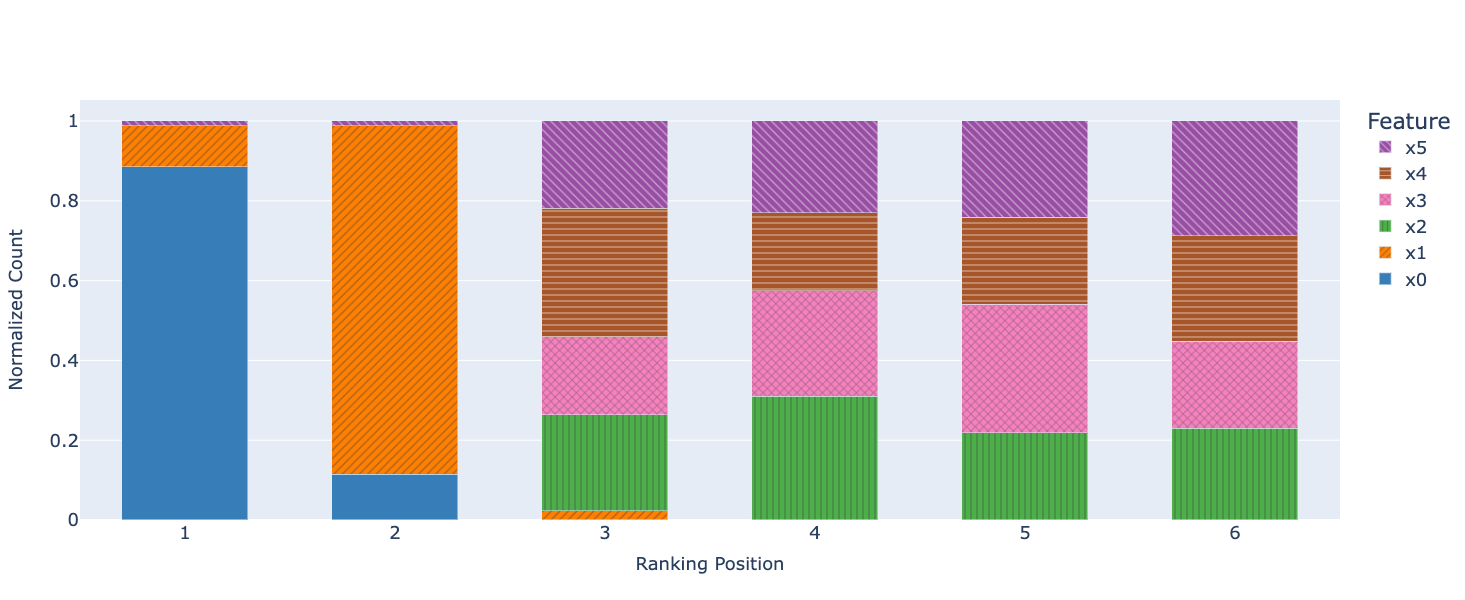

In [17]:
ranking_xaxis_shap_fig = feature_importance_distribution_barplot(shap_x_feature_ranking)
ranking_xaxis_shap_fig.update_layout(width=10*100, height=6*100, font=dict(size=18))

ranking_yaxis_shap_fig = feature_importance_distribution_barplot(shap_y_feature_ranking)
ranking_yaxis_shap_fig.update_layout(width=10*100, height=6*100, font=dict(size=18))

ranking_bisec_shap_fig = feature_importance_distribution_barplot(shap_bisec_feature_ranking)
ranking_bisec_shap_fig.update_layout(width=10*100, height=6*100, font=dict(size=18))

ranking_xaxis_shap_fig.show()
ranking_yaxis_shap_fig.show()
ranking_bisec_shap_fig.show()